In [1]:
import matplotlib.pyplot as plt
import seaborn as sns  
from bioinfokit import analys, visuz
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score,adjusted_rand_score,normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import warnings
from clinical_analysis_utils import rank_proteins_and_volcano_plot

warnings.filterwarnings("ignore")

In [2]:
adata_raw = sc.read_h5ad('./data/ECCITE_seq_processed.h5ad')
embedding = np.load('./data/z_ECCITE_seq.npy')
adata_scPROTEIN = ad.AnnData(embedding)
adata_scPROTEIN.obs['donor_type'] = adata_raw.obs['donor_type']

In [3]:
sc.pp.neighbors(adata_scPROTEIN, n_neighbors=15,use_rep='X')
sc.tl.leiden(adata_scPROTEIN,resolution = 0.6,key_added = "leiden")  

In [4]:
adata_scPROTEIN

AnnData object with n_obs × n_vars = 5401 × 32
    obs: 'donor_type', 'leiden'
    uns: 'neighbors', 'leiden'
    obsp: 'distances', 'connectivities'

In [5]:
adata_scPROTEIN.obs['leiden']

0        4
1        0
2       10
3        7
4       11
        ..
5396    24
5397    15
5398    17
5399    15
5400     3
Name: leiden, Length: 5401, dtype: category
Categories (26, object): ['0', '1', '2', '3', ..., '22', '23', '24', '25']

### UMAP plot showing the cells colored by clusters

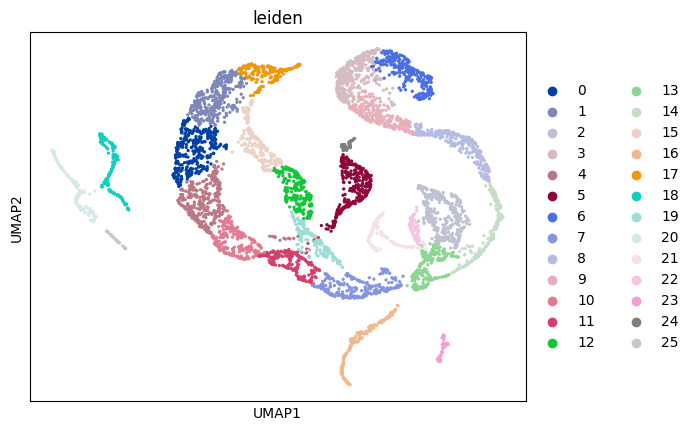

In [6]:
sc.tl.umap(adata_scPROTEIN,n_components=2)
sc.pl.umap(adata_scPROTEIN, color="leiden")

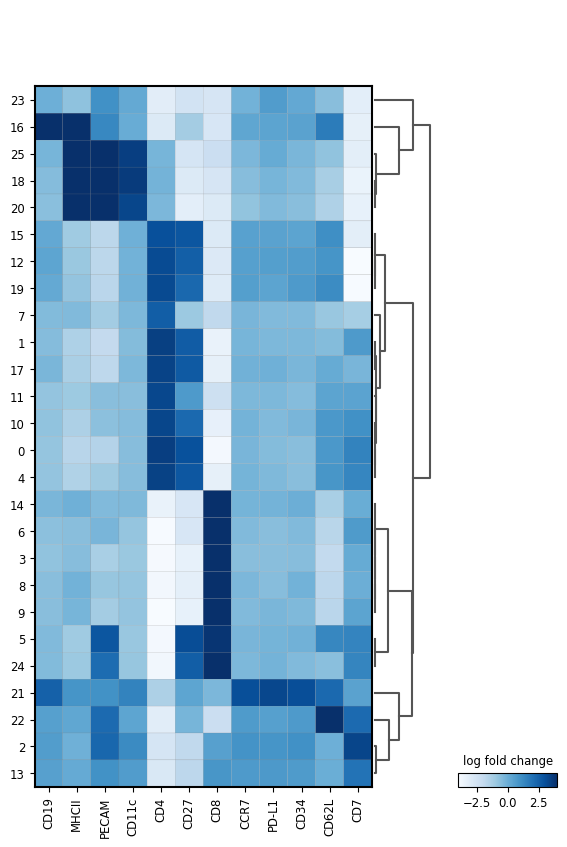

In [7]:
adata_raw.obs['leiden'] = adata_scPROTEIN.obs['leiden']
markers = ['CD19', 'MHCII', 'PECAM', 'CD11c', 'CD4', 'CD27','CD8','CCR7','PD-L1','CD34','CD62L','CD7']

sc.tl.rank_genes_groups(adata_raw, 'leiden')
sc.pl.rank_genes_groups_matrixplot(
    adata_raw,
    values_to_plot="logfoldchanges",
    var_names = markers,
    cmap='Blues',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
)

### Combine similar clusters

We perform subcluster detection at a higher resolution, further hoping to find markers that cannot be detected at lower resolution. We then combined the clusters with similar pattern such as 12,15,19/14,6,3,8,9/25,18,20 and construct a new adata.

In [8]:
cluster_label = list(adata_raw.obs['leiden'])
combine_cluster_list1 = ['15','12','19']
combine_cluster_list2 = ['14','6','3','8','9']
combine_cluster_list3 = ['25','18','20']
new_cluster_label = ['12' if i in combine_cluster_list1 else i for i in cluster_label]
new_cluster_label = ['3' if i in combine_cluster_list2 else i for i in new_cluster_label]
new_cluster_label = ['18' if i in combine_cluster_list3 else i for i in new_cluster_label]

unique_cluster = list(pd.unique(new_cluster_label))
new_cluster_label = [str(unique_cluster.index(i)) for i in new_cluster_label]

In [9]:
unique_cluster

['4',
 '0',
 '10',
 '7',
 '11',
 '1',
 '13',
 '3',
 '17',
 '16',
 '18',
 '2',
 '21',
 '5',
 '24',
 '22',
 '12',
 '23']

In [10]:
adata_raw_reorder = ad.AnnData(adata_raw.X)
adata_raw_reorder.var_names = adata_raw.var_names
adata_raw_reorder.obs['donor_type'] = adata_raw.obs['donor_type']
adata_raw_reorder.obs['new_cluster_label'] = pd.Categorical(new_cluster_label)
adata_raw_reorder.obs['new_cluster_label']

0        0
1        1
2        2
3        3
4        4
        ..
5396    14
5397    16
5398     8
5399    16
5400     7
Name: new_cluster_label, Length: 5401, dtype: category
Categories (18, object): ['0', '1', '10', '11', ..., '6', '7', '8', '9']

### Heatmap showing the protein levels across new clusters

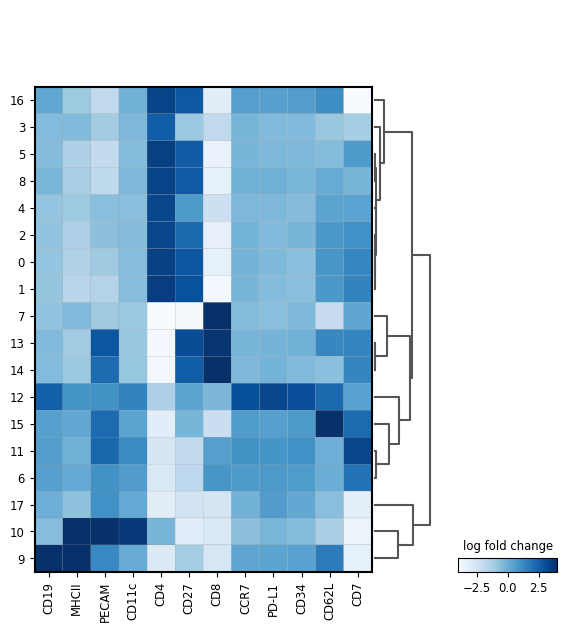

In [11]:
sc.tl.rank_genes_groups(adata_raw_reorder, 'new_cluster_label')
sc.pl.rank_genes_groups_matrixplot(
    adata_raw_reorder,
    values_to_plot="logfoldchanges",
    var_names = markers,
    cmap='Blues',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
)

In [12]:
adata_scPROTEIN.obs['new_cluster_label'] = adata_raw_reorder.obs['new_cluster_label']
adata_scPROTEIN

AnnData object with n_obs × n_vars = 5401 × 32
    obs: 'donor_type', 'leiden', 'new_cluster_label'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

### UMAP plot showing the cells colored by new clusters
We can then plot the umap of scPROTEIN with the new combined cluster labels

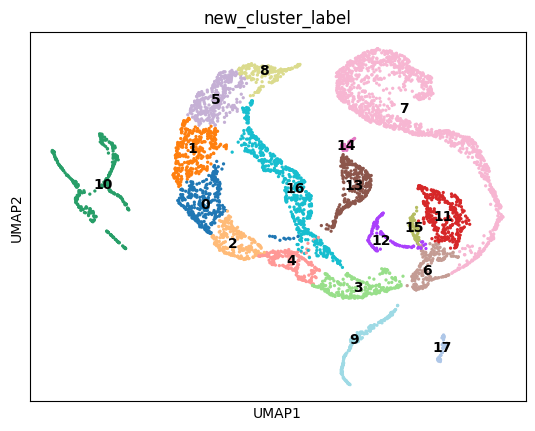

In [13]:
sc.pl.umap(adata_scPROTEIN, color="new_cluster_label",legend_loc='on data')

In [14]:
adata_raw_reorder.obs['new_cluster_label']

0        0
1        1
2        2
3        3
4        4
        ..
5396    14
5397    16
5398     8
5399    16
5400     7
Name: new_cluster_label, Length: 5401, dtype: category
Categories (18, object): ['0', '1', '10', '11', ..., '6', '7', '8', '9']

In [15]:
unique_cluster

['4',
 '0',
 '10',
 '7',
 '11',
 '1',
 '13',
 '3',
 '17',
 '16',
 '18',
 '2',
 '21',
 '5',
 '24',
 '22',
 '12',
 '23']

### Cell marker detection within subcluster

Take subcluster 7 as an example to illusrate

In [16]:
adata_raw_reorder_7 = adata_raw_reorder[adata_raw_reorder.obs['new_cluster_label']=='7']
sc.tl.rank_genes_groups(adata_raw_reorder_7, groupby = 'donor_type', method='t-test')

A pie plot showing the ratio of cells from two donors in this subcluster

([<matplotlib.patches.Wedge at 0x7f8f1c05ebb0>,
 [Text(-0.7075112018882697, 0.8422754295375214, 'control'),
  Text(0.7718303160313631, -0.9188459953958151, 'patient')],
 [Text(-0.38591520102996524, 0.4594229615659207, '72.2%'),
  Text(0.45023435101829506, -0.5359934973142254, '27.8%')])

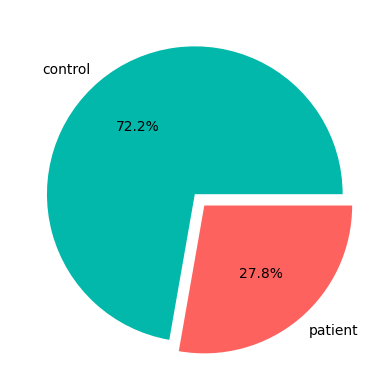

In [17]:
fig, ax = plt.subplots()
labels = 'control', 'patient'
sizes = [adata_raw_reorder_7[adata_raw_reorder_7.obs['donor_type']==0].X.shape[0],adata_raw_reorder_7[adata_raw_reorder_7.obs['donor_type']==1].X.shape[0],]

ax.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['#01b8aa','#fd625e'],explode=[0.,0.1])

In [18]:
rank_proteins_and_volcano_plot(adata_raw_reorder_7)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


top 5 upregulated proteins: ['PD1', 'CD2', 'LAMP1', 'CD366', 'EpCAM']


A volcano plot showing upregulated (green) and downregulated (red) will be saved in this directory.

Take another subcluster 13 as an example to illusrate

In [19]:
adata_raw_reorder_13 = adata_raw_reorder[adata_raw_reorder.obs['new_cluster_label']=='13']
sc.tl.rank_genes_groups(adata_raw_reorder_13, groupby = 'donor_type', method='t-test')

([<matplotlib.patches.Wedge at 0x7f8fc4a4b670>,
 [Text(0.964163760875781, 0.5295169895422335, 'control'),
  Text(-1.0518150118644884, -0.5776548976824365, 'patient')],
 [Text(0.5259075059322441, 0.28882744884121825, '16.0%'),
  Text(-0.6135587569209515, -0.33696535698142127, '84.0%')])

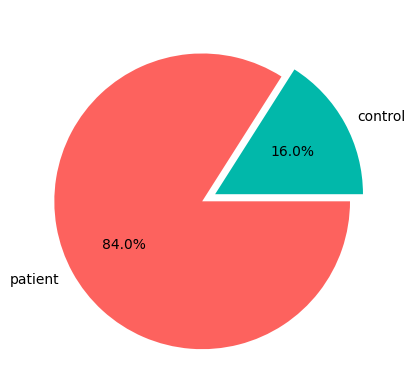

In [20]:
fig, ax = plt.subplots()
labels = 'control', 'patient'
sizes = [adata_raw_reorder_13[adata_raw_reorder_13.obs['donor_type']==0].X.shape[0],adata_raw_reorder_13[adata_raw_reorder_13.obs['donor_type']==1].X.shape[0],]

ax.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['#01b8aa','#fd625e'],explode=[0.,0.1])

In [21]:
rank_proteins_and_volcano_plot(adata_raw_reorder_13)

top 5 upregulated proteins: ['CD62L', 'LAMP1', 'CD366', 'CD138', 'EpCAM']


Similar analysis for other subclusters can also be performed.

In [22]:
adata_raw_reorder_11 = adata_raw_reorder[adata_raw_reorder.obs['new_cluster_label']=='11']
sc.tl.rank_genes_groups(adata_raw_reorder_11, groupby = 'donor_type', method='t-test')

([<matplotlib.patches.Wedge at 0x7f8fc48b5af0>,
 [Text(-0.053974441760159815, 1.0986750018256897, 'control'),
  Text(0.0588812091929012, -1.198554547446207, 'patient')],
 [Text(-0.029440604596450804, 0.5992772737231035, '51.6%'),
  Text(0.034347372029192365, -0.6991568193436207, '48.4%')])

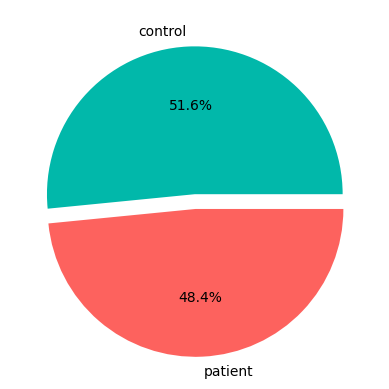

In [23]:
fig, ax = plt.subplots()
labels = 'control', 'patient'
sizes = [adata_raw_reorder_11[adata_raw_reorder_11.obs['donor_type']==0].X.shape[0],adata_raw_reorder_11[adata_raw_reorder_11.obs['donor_type']==1].X.shape[0],]

ax.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['#01b8aa','#fd625e'],explode=[0.,0.1])

In [24]:
rank_proteins_and_volcano_plot(adata_raw_reorder_11)

top 5 upregulated proteins: ['CD2', 'LAMP1', 'PD1', 'EpCAM', 'Siglec-8']
